# Greetings

In this spam/ham example using a kaggle dataset, I will attempt to explore a few things
- Count vectoriser vs tfidf
- The different nature of the models

# Imports

In [1]:
import pandas as pd
import os
from typing import List
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import urllib.request
import zipfile
import warnings
import spacy
from langdetect import detect
from wordcloud import WordCloud
import kaggle

from kaggle.api.kaggle_api_extended import KaggleApi

from sklearn.model_selection import train_test_split

warnings.filterwarnings('ignore')

TEST_SIZE = 0.10
SEED = 42
# Wider view
pd.set_option('max_colwidth', 1000)

In [2]:
data_path = 'spam.csv'

api = KaggleApi()
api.authenticate()

api.dataset_download_file('uciml/sms-spam-collection-dataset',
                          file_name=data_path,
                          path='./')

False

# Read files

In [3]:
df = pd.read_csv(data_path, encoding='ISO-8859-1')

In [4]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives around here though",NaN,NaN,NaN


In [5]:
df = df.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'], axis=1)
df.columns = ['spam','text']
df.spam = df.spam.apply(lambda x: 0 if x == 'ham' else 1)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   spam    5572 non-null   int64 
 1   text    5572 non-null   object
dtypes: int64(1), object(1)
memory usage: 87.2+ KB


The data is not incredibly imbalanced. I want to retain this ratio in the test and val sets so I stratify on the target col.

In [7]:
df.spam.value_counts()

0    4825
1     747
Name: spam, dtype: int64

In [8]:
df.spam.value_counts(normalize=True)

0    0.865937
1    0.134063
Name: spam, dtype: float64

In [9]:
df.head()

,spam,text
0,0,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives around here though"


In [10]:
df.head()

,spam,text
0,0,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives around here though"


In [11]:
train_df, val_df = train_test_split(df,test_size=TEST_SIZE,random_state=SEED, stratify=df['spam'])

In [12]:
val_df, test_df = train_test_split(val_df,test_size=0.5,random_state=SEED, stratify=val_df['spam'])

In [13]:
df_value_count = pd.concat([train_df.spam.value_counts(normalize=True),\
    val_df.spam.value_counts(normalize=True),\
        test_df.spam.value_counts(normalize=True)], axis=1)

In [14]:
df_value_count.columns = ['train set','val set', 'test set']

In [15]:
df_value_count

,train set,val set,test set
0,0.865975,0.863799,0.867384
1,0.134025,0.136201,0.132616


In [16]:
def return_train_val_test_sets(df:pd.DataFrame, test_size:float=TEST_SIZE, stratify:bool=True)->List[pd.DataFrame]:
    """returns the train val test set, making the columns correct."""
    df = pd.read_csv(data_path, encoding='ISO-8859-1')
    df.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'], axis=1, inplace= True)
    df.columns = ['spam','text']
    df.spam = df.spam.apply(lambda x: 0 if x == 'ham' else 1)

    if stratify:
        train_df, val_df = train_test_split(df,test_size=TEST_SIZE,random_state=SEED, stratify=df['spam'])
        val_df, test_df = train_test_split(val_df,test_size=0.5,random_state=SEED, stratify=val_df['spam'])

        return train_df, val_df, test_df
    else:
        train_df, val_df = train_test_split(df,test_size=TEST_SIZE,random_state=SEED)
        val_df, test_df = train_test_split(val_df,test_size=0.5,random_state=SEED)

        return train_df, val_df, test_df

# EDA

We have 5014 datapoints in train, 279 in val and 279 in test

In [17]:
train_df

,spam,text
3398,0,"Yeah we wouldn't leave for an hour at least, how's 4 sound?"
3325,0,Huh so fast... Dat means u havent finished painting?
2498,0,"I know where the &lt;#&gt; is, I'll be there around 5"
1553,0,Ok how you dear. Did you call chechi
46,0,Didn't you get hep b immunisation in nigeria.
...,...,...
1932,0,Jus finished avatar nigro
5316,0,Jus finish watching tv... U?
5203,0,Me fine..absolutly fine
563,1,GENT! We are trying to contact you. Last weekends draw shows that you won a å£1000 prize GUARANTEED. Call 09064012160. Claim Code K52. Valid 12hrs only. 150ppm


In [18]:
val_df

,spam,text
4901,1,* FREE* POLYPHONIC RINGTONE Text SUPER to 87131 to get your FREE POLY TONE of the week now! 16 SN PoBox202 NR31 7ZS subscription 450pw
2638,0,Am in gobi arts college
3290,0,"I'm not smoking while people use \wylie smokes too much\"" to justify ruining my shit"""
600,0,Mind blastin.. No more Tsunamis will occur from now on.. Rajnikant stopped swimming in Indian Ocean..:-D
3852,0,"Dont worry, 1 day very big lambu ji vl come..til then enjoy batchlor party:-)"
...,...,...
24,0,Ffffffffff. Alright no way I can meet up with you sooner?
5440,0,Thank you. do you generally date the brothas?
1226,1,Reply with your name and address and YOU WILL RECEIVE BY POST a weeks completely free accommodation at various global locations www.phb1.com ph:08700435505150p
2505,0,Congrats kano..whr s the treat maga?


We do not inspect test set in order to prevent data snooping

In [19]:

len(test_df)

279

In [20]:
test_df.shape

(279, 2)

In [21]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5014 entries, 3398 to 763
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   spam    5014 non-null   int64 
 1   text    5014 non-null   object
dtypes: int64(1), object(1)
memory usage: 117.5+ KB


## Check for duplicates

Checking for na very briefly

In [22]:
train_df.isna().sum()

spam    0
text    0
dtype: int64

We have 322 that are duplicates

In [23]:
train_df[train_df['text'].duplicated()]

,spam,text
5171,0,Oh k. . I will come tomorrow
3298,0,"Honeybee Said: *I'm d Sweetest in d World* God Laughed &amp; Said: *Wait,U Havnt Met d Person Reading This Msg* MORAL: Even GOD Can Crack Jokes! GM+GN+GE+GN:)"
443,0,"Sorry, I'll call later"
283,0,Okie...
1426,0,Ok...
...,...,...
1566,0,I am late. I will be there at
980,0,If he started searching he will get job in few days.he have great potential and talent.
5029,0,Is there coming friday is leave for pongal?do you get any news from your work place.
4160,1,Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with camera for Free! Call The Mobile Update Co FREE on 08002986030


In [24]:
train_df = train_df.drop_duplicates()

## Check NA

In [25]:
train_df.isna().any()

spam    False
text    False
dtype: bool

## Check for other languages

In [26]:
train_df['text'][0]

'Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...'

In [27]:
detect(train_df['text'][3])

'en'

In [28]:
try: 
    train_df['language'] = train_df['text'].apply(lambda x : detect(x)) 
except Exception as e:
    print(f'Unable to print due to error {e}')

Unable to print due to error No features in text.


In [29]:
# Empty text detected
language_list = []
for idx, text in enumerate(train_df['text']):
    try:
        language_list.append(detect(text))
    except:
        print(f"Error at idx : {idx} \n for text : {text} \n appending Error")
        language_list.append('Error')
else:
    print("Completed")

Error at idx : 1403 
 for text : :-) :-) 
 appending Error
Error at idx : 1625 
 for text : 645 
 appending Error
Error at idx : 3242 
 for text : :)  
 appending Error
Completed


In [30]:
train_df['language'] = language_list

In [31]:
train_df['language'].value_counts()

en       4292
af         55
nl         31
so         31
fr         29
no         28
cy         28
id         26
de         23
it         21
da         17
tl         16
sv         12
ca         12
sw         10
et          9
hr          8
vi          7
sl          6
es          6
sq          6
sk          5
pl          4
Error       3
tr          3
pt          2
hu          1
ro          1
Name: language, dtype: int64

In [32]:
train_df[train_df['language']=='Error']

,spam,text,language
4822,0,:-) :-),Error
1611,0,645,Error
3374,0,:),Error


In [33]:
# Czech
train_df[train_df['language']=='cs']

,spam,text,language


In [34]:
# Slovenian
train_df[train_df['language']=='sl']

,spam,text,language
361,0,Oh ok no prob..,sl
220,0,Ok no prob. Take ur time.,sl
149,0,Sindu got job in birla soft ..,sl
4660,0,Ok no prob...,sl
2713,0,Nope i'm not drivin... I neva develop da photos lei...,sl
3514,0,I'm job profile seems like bpo..,sl


In [35]:
# Apparently Singlish can be interpreted as many other languages
train_df[train_df['language']=='tl']

,spam,text,language
203,0,Goodmorning sleeping ga.,tl
3382,0,K... Must book a not huh? so going for yoga basic on sunday?,tl
1185,0,Annoying isn't it.,tl
2746,0,K da:)how many page you want?,tl
2906,0,ALRITE,tl
4935,0,K..k.:)congratulation ..,tl
2461,0,Anything lar...,tl
667,0,This pay is &lt;DECIMAL&gt; lakhs:),tl
4980,0,I said its okay. Sorry,tl
315,0,K.k:)advance happy pongal.,tl


Does not provide us much value since most are in en and the majority of text are categorised as english. This would be good if say the spam messages somehow gets classified as a particular language.

<AxesSubplot:ylabel='language'>

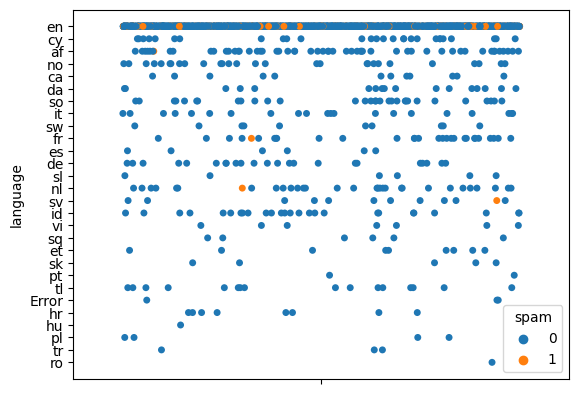

In [36]:
sns.stripplot(data=train_df, y='language',jitter=0.4, hue='spam')

## Remove Empty and add Length feature

In [37]:
train_df.drop(columns='language', inplace= True)

In [38]:
# remove trailing and leading spaces
train_df['length'] = train_df['text'].apply(lambda x : len(x.strip()))

In [39]:
train_df.iloc[1760]

spam                                                                                     0
text      So are you guys asking that i get that slippers again or its gone with last year
length                                                                                  80
Name: 2545, dtype: object

In [40]:
train_df.iloc[3885]

spam                                                                                          0
text      Dis is yijue. I jus saw ur mail. In case huiming havent sent u my num. Dis is my num.
length                                                                                       85
Name: 346, dtype: object

In [41]:
empty_indicies = train_df[train_df['length']==0].index

In [42]:
train_df.drop(index=empty_indicies, inplace= True)

In [43]:
train_df

,spam,text,length
3398,0,"Yeah we wouldn't leave for an hour at least, how's 4 sound?",59
3325,0,Huh so fast... Dat means u havent finished painting?,52
2498,0,"I know where the &lt;#&gt; is, I'll be there around 5",55
1553,0,Ok how you dear. Did you call chechi,36
46,0,Didn't you get hep b immunisation in nigeria.,45
...,...,...,...
2329,0,Am surfing online store. For offers do you want to buy any thing.,65
1932,0,Jus finished avatar nigro,25
5316,0,Jus finish watching tv... U?,28
563,1,GENT! We are trying to contact you. Last weekends draw shows that you won a å£1000 prize GUARANTEED. Call 09064012160. Claim Code K52. Valid 12hrs only. 150ppm,159


In [44]:
len(train_df)

4692

I can consider this feature since spams (1) tend to be on average, longer than their counterparts

<AxesSubplot:xlabel='spam', ylabel='length'>

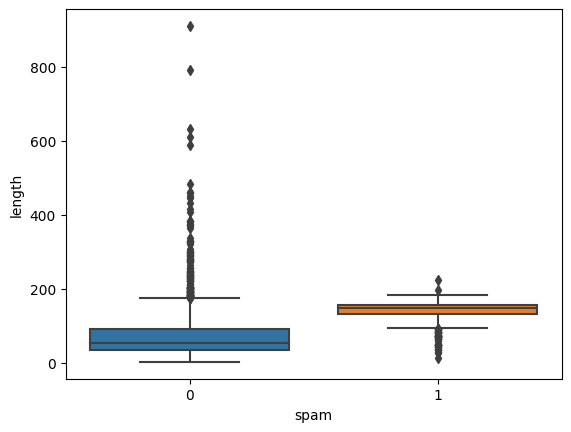

In [45]:
sns.boxplot(data = train_df, x='spam', y= 'length')

## Explore spam

In [46]:
# not incredibly imbalanced (like 99% to 1%)
train_df['spam'].value_counts(normalize=True)

0    0.872549
1    0.127451
Name: spam, dtype: float64

In [47]:
train_df['spam'].value_counts()

0    4094
1     598
Name: spam, dtype: int64

In [48]:
val_df['spam'].value_counts(normalize=True)

0    0.863799
1    0.136201
Name: spam, dtype: float64

In [49]:
val_df['spam'].value_counts()

0    241
1     38
Name: spam, dtype: int64

Lets pick out 20 and see what we can observe to come out with some features

In [50]:
train_df[train_df['spam']==1].sample(20, random_state=SEED)

,spam,text,length
332,1,Call Germany for only 1 pence per minute! Call from a fixed line via access number 0844 861 85 85. No prepayment. Direct access!,128
4154,1,Want a new Video Phone? 750 anytime any network mins? Half price line rental free text for 3 months? Reply or call 08000930705 for free delivery,144
56,1,"Congrats! 1 year special cinema pass for 2 is yours. call 09061209465 now! C Suprman V, Matrix3, StarWars3, etc all 4 FREE! bx420-ip4-5we. 150pm. Dont miss out!",160
2869,1,"YOUR CHANCE TO BE ON A REALITY FANTASY SHOW call now = 08707509020 Just 20p per min NTT Ltd, PO Box 1327 Croydon CR9 5WB 0870 is a national = rate call.",152
1612,1,RT-KIng Pro Video Club>> Need help? info@ringtoneking.co.uk or call 08701237397 You must be 16+ Club credits redeemable at www.ringtoneking.co.uk! Enjoy!,153
2802,1,FreeMsg>FAV XMAS TONES!Reply REAL,33
2359,1,"Spook up your mob with a Halloween collection of a logo & pic message plus a free eerie tone, txt CARD SPOOK to 8007 zed 08701417012150p per logo/pic",149
4458,1,"Welcome to UK-mobile-date this msg is FREE giving you free calling to 08719839835. Future mgs billed at 150p daily. To cancel send \go stop\"" to 89123""",151
2429,1,Guess who am I?This is the first time I created a web page WWW.ASJESUS.COM read all I wrote. I'm waiting for your opinions. I want to be your friend 1/1,152
3940,1,"Free Msg: get Gnarls Barkleys \Crazy\"" ringtone TOTALLY FREE just reply GO to this message right now!""",102


In [51]:
train_df[train_df['spam']==0].sample(20, random_state=SEED)

,spam,text,length
2733,0,Do Ì_ noe if ben is going?,26
3781,0,How r Ì_ going to send it to me?,32
3523,0,Yeah that'd pretty much be the best case scenario,49
3487,0,Still i have not checked it da. . .,35
5295,0,Alex says he's not ok with you not being ok with it,51
1027,0,Are you not around or just still asleep? :V,43
4622,0,"U need my presnts always bcz U cant mis love. \jeevithathile irulinae neekunna prakasamanu sneham\"" prakasam ennal prabha 'That mns prabha is'LOVE' Got it. Dont mis me....""",172
1518,0,Shall i ask one thing if you dont mistake me.,45
5094,0,"Hi Shanil,Rakhesh here.thanks,i have exchanged the uncut diamond stuff.leaving back. Excellent service by Dino and Prem.",120
4411,0,If i said anything wrong sorry de:-),36


In [52]:
# We can use some visualisation
train_df_scam = train_df[train_df['spam']==1]
train_df_gen = train_df[train_df['spam']!=1]
scam_corpus = ''.join(word for word in train_df_scam.text)
gen_corpus = ''.join(word for word in train_df_gen.text)

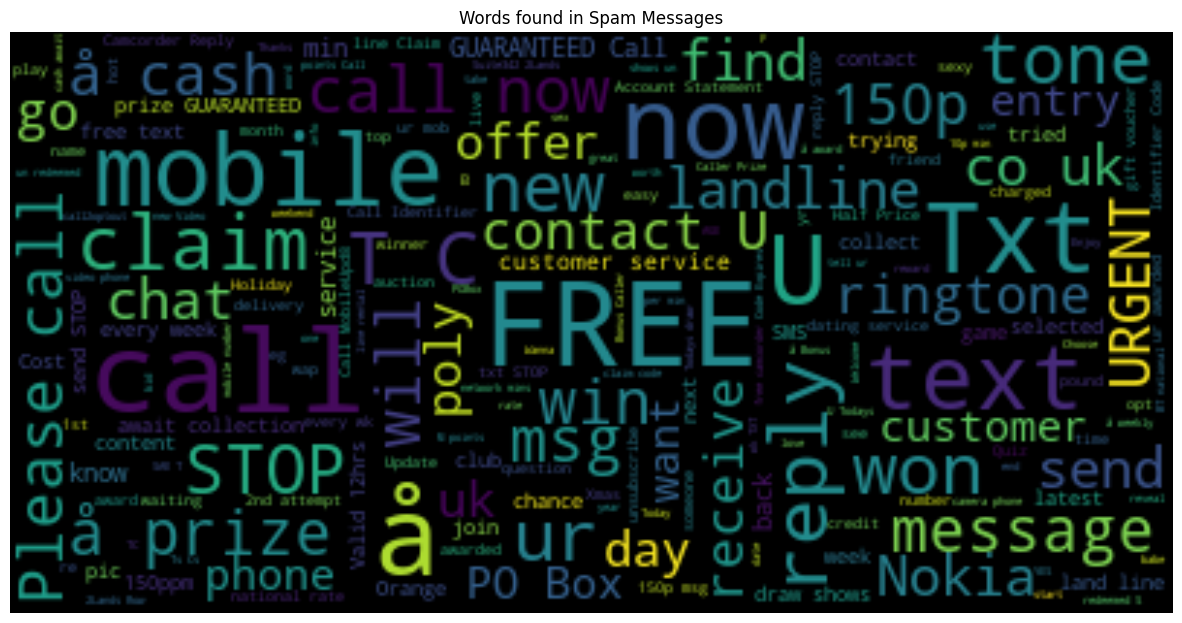

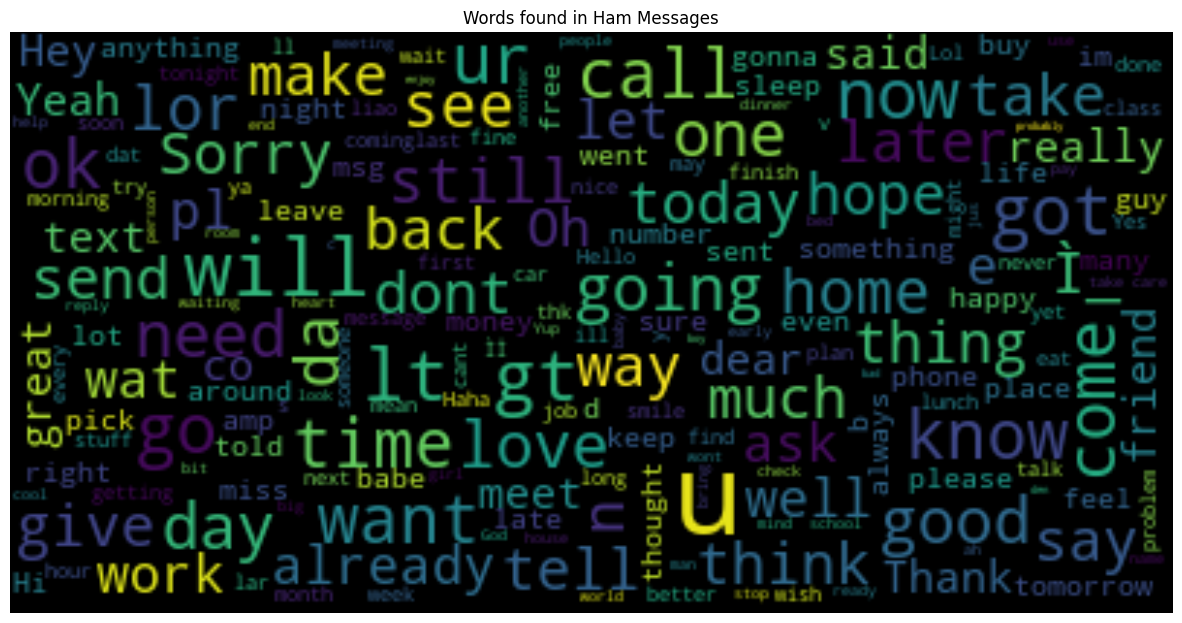

In [53]:
# code taken from wordcloud tutorial
# Generate a word cloud image
wordcloud_scam = WordCloud(max_font_size=40).generate(scam_corpus)
wordcloud_gen = WordCloud(max_font_size=40).generate(gen_corpus)

# Display the generated image:
# the matplotlib way:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,15))
plt.imshow(wordcloud_scam, interpolation='bilinear')
plt.title("Words found in Spam Messages")
plt.axis("off")

# lower max_font_size
plt.figure(figsize=(15,15))
plt.title("Words found in Ham Messages")
plt.imshow(wordcloud_gen, interpolation="bilinear")
plt.axis("off")
plt.show()

# The pil way (if you don't have matplotlib)
# image = wordcloud.to_image()
# image.show()

Some spam signs are possibly:
- containing words like
  - call
  - txt
  - now
  - won
  - free
- some $ or phone number or some prize money. I see money also is used in some genuine text
- Websites or URL being placed in some spam messages
- perhaps length? I see(read) somewhere length is a predictor

# Feature Engineering

## Words

- Try words like
  - money
  - prize
  - win
  - reward
  - winner
  - lucky

In [54]:
train_df_scamy= train_df[train_df['text'].str.contains('money') | \
    train_df['text'].str.contains('prize') | \
    train_df['text'].str.contains('win') | \
    train_df['text'].str.contains('prize') | \
    train_df['text'].str.contains('win') | \
    train_df['text'].str.contains('reward') | \
    train_df['text'].str.contains('winner')| \
    train_df['text'].str.contains('lucky')]

In [55]:
train_df_scamy

,spam,text,length
3582,0,I sent your maga that money yesterday oh.,41
507,0,You should know now. So how's anthony. Are you bringing money. I've school fees to pay and rent and stuff like that. Thats why i need your help. A friend in need....|,166
812,1,Congratulations ur awarded either å£500 of CD gift vouchers & Free entry 2 our å£100 weekly draw txt MUSIC to 87066 TnCs www.Ldew.com1win150ppmx3age16,150
1535,1,You have won a Nokia 7250i. This is what you get when you win our FREE auction. To take part send Nokia to 86021 now. HG/Suite342/2Lands Row/W1JHL 16+,150
4278,1,"URGENT. Important information for 02 user. Today is your lucky day! 2 find out why , log onto http://www.urawinner.com there is a fantastic surprise awaiting you !",163
...,...,...,...
4100,1,GSOH? Good with SPAM the ladies?U could b a male gigolo? 2 join the uk's fastest growing mens club reply ONCALL. mjzgroup. 08714342399.2stop reply STOP. msg@å£1.50rcvd,167
4103,0,Do u hav any frnd by name ashwini in ur college?,48
1560,0,"Just got some gas money, any chance you and the gang want to go on a grand nature adventure?",92
4256,1,important information 4 orange user . today is your lucky day!2find out why log onto http://www.urawinner.com THERE'S A FANTASTIC SURPRISE AWAITING YOU!,152


In [56]:
train_df_scamy['spam'].value_counts(normalize=True)

1    0.514151
0    0.485849
Name: spam, dtype: float64

In [57]:
# We have 640 scam texts and the feature got 146 which aint bad but has false positives coz it caught some negatives.
# hopefully this feature when combined with others turns out to be good
train_df_scamy['spam'].value_counts()

1    109
0    103
Name: spam, dtype: int64

In [58]:
train_df_scamy= train_df[train_df['text'].str.contains('call') | \
    train_df['text'].str.contains('text') | \
    train_df['text'].str.contains('won') | \
    train_df['text'].str.contains('free')]

In [59]:
# I noticed in the examples especially the first one it is caught because 'win' is a substring of 'wind' 
# If possible I will catch only whole words 
train_df_scamy

,spam,text,length
1553,0,Ok how you dear. Did you call chechi,36
1831,0,Hello- thanx for taking that call. I got a job! Starts on monday!,65
3321,0,Ok darlin i supose it was ok i just worry too much.i have to do some film stuff my mate and then have to babysit again! But you can call me there.xx,148
1535,1,You have won a Nokia 7250i. This is what you get when you win our FREE auction. To take part send Nokia to 86021 now. HG/Suite342/2Lands Row/W1JHL 16+,150
1759,0,Do u ever get a song stuck in your head for no reason and it won't go away til u listen to it like 5 times?,107
...,...,...,...
909,1,"January Male Sale! Hot Gay chat now cheaper, call 08709222922. National rate from 1.5p/min cheap to 7.8p/min peak! To stop texts call 08712460324 (10p/min)",155
3799,1,We tried to contact you re your reply to our offer of a Video Handset? 750 anytime any networks mins? UNLIMITED TEXT? Camcorder? Reply or call 08000930705 NOW,158
5138,0,Yup... I havent been there before... You want to go for the yoga? I can call up to book,87
563,1,GENT! We are trying to contact you. Last weekends draw shows that you won a å£1000 prize GUARANTEED. Call 09064012160. Claim Code K52. Valid 12hrs only. 150ppm,159


In [60]:
train_df_scamy['spam'].value_counts(normalize=True)

0    0.564541
1    0.435459
Name: spam, dtype: float64

We have 747 scam texts and the feature got 280 which aint bad but has false positives coz it caught some negatives.
hopefully this feature when combined with others turns out to be good

In [61]:

train_df_scamy['spam'].value_counts()

0    363
1    280
Name: spam, dtype: int64

In [62]:
train_df_scamy= train_df[train_df['text'].str.contains('money') | \
    train_df['text'].str.contains('prize') | \
    train_df['text'].str.contains('win') | \
    train_df['text'].str.contains('prize') | \
    train_df['text'].str.contains('win') | \
    train_df['text'].str.contains('reward') | \
    train_df['text'].str.contains('winner')| \
    train_df['text'].str.contains('lucky') | \
    train_df['text'].str.contains('call') | \
    train_df['text'].str.contains('text') | \
    train_df['text'].str.contains('won') | \
    train_df['text'].str.contains('free')]

In [63]:
train_df_scamy['spam'].value_counts(normalize=True)

0    0.578145
1    0.421855
Name: spam, dtype: float64

The smaller list have a higher recall but lesser precision and increasing the number of words provide only marginal benefits

In [64]:
train_df_scamy['spam'].value_counts()

0    455
1    332
Name: spam, dtype: int64

In [65]:
scamy_words = ['call','text','won','now','free']

In [66]:
train_df['scamy_words']= train_df['text'].apply(lambda x: any([k in x for k in scamy_words]))

In [67]:
train_df['scamy_words'] = train_df['scamy_words'].astype('int')

In [68]:
train_df

,spam,text,length,scamy_words
3398,0,"Yeah we wouldn't leave for an hour at least, how's 4 sound?",59,0
3325,0,Huh so fast... Dat means u havent finished painting?,52,0
2498,0,"I know where the &lt;#&gt; is, I'll be there around 5",55,1
1553,0,Ok how you dear. Did you call chechi,36,1
46,0,Didn't you get hep b immunisation in nigeria.,45,0
...,...,...,...,...
2329,0,Am surfing online store. For offers do you want to buy any thing.,65,0
1932,0,Jus finished avatar nigro,25,0
5316,0,Jus finish watching tv... U?,28,0
563,1,GENT! We are trying to contact you. Last weekends draw shows that you won a å£1000 prize GUARANTEED. Call 09064012160. Claim Code K52. Valid 12hrs only. 150ppm,159,1


<AxesSubplot:>

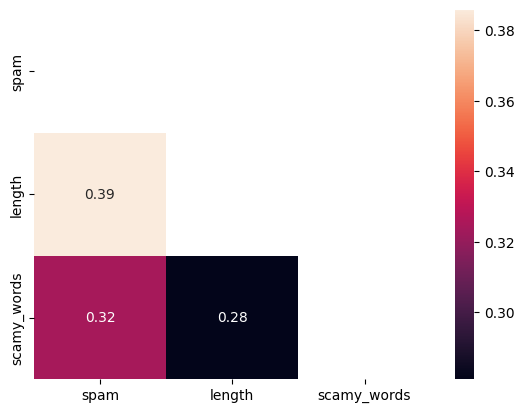

In [69]:
mask = np.triu(train_df.corr())
sns.heatmap(train_df.corr(), annot=True, fmt=".2f", mask= mask)

## Numbers

In [70]:
train_df['numbers']= train_df['text'].str.extract(r"(\d+)")

In [71]:
train_df[train_df.numbers.isna() == False]['numbers'] = 1

In [72]:
train_df.numbers.fillna(0, inplace=True)

In [73]:
train_df['numbers'] = train_df['numbers'].apply(lambda x: 1 if x !=0 else 0)

In [74]:
train_df

,spam,text,length,scamy_words,numbers
3398,0,"Yeah we wouldn't leave for an hour at least, how's 4 sound?",59,0,1
3325,0,Huh so fast... Dat means u havent finished painting?,52,0,0
2498,0,"I know where the &lt;#&gt; is, I'll be there around 5",55,1,1
1553,0,Ok how you dear. Did you call chechi,36,1,0
46,0,Didn't you get hep b immunisation in nigeria.,45,0,0
...,...,...,...,...,...
2329,0,Am surfing online store. For offers do you want to buy any thing.,65,0,0
1932,0,Jus finished avatar nigro,25,0,0
5316,0,Jus finish watching tv... U?,28,0,0
563,1,GENT! We are trying to contact you. Last weekends draw shows that you won a å£1000 prize GUARANTEED. Call 09064012160. Claim Code K52. Valid 12hrs only. 150ppm,159,1,1


In [75]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4692 entries, 3398 to 763
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   spam         4692 non-null   int64 
 1   text         4692 non-null   object
 2   length       4692 non-null   int64 
 3   scamy_words  4692 non-null   int32 
 4   numbers      4692 non-null   int64 
dtypes: int32(1), int64(3), object(1)
memory usage: 330.6+ KB


<AxesSubplot:>

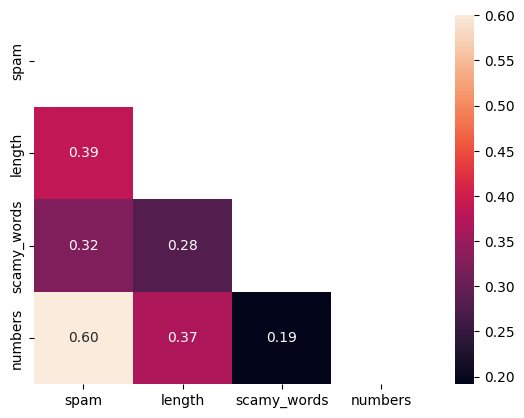

In [76]:
mask = np.triu(train_df.corr())
sns.heatmap(train_df.corr(), annot=True, fmt=".2f", mask= mask)

## Text itself

### Count Vectorizer

In [77]:
from sklearn.feature_extraction.text import CountVectorizer

In [78]:
bow = CountVectorizer()
bow.fit(train_df['text'])
countvec_X = bow.transform(train_df['text'])

In [79]:
countvec_X_df = pd.DataFrame(countvec_X.toarray(), columns=sorted(bow.vocabulary_))
countvec_X_df


,00,000,008704050406,0089,0121,01223585236,01223585334,0125698789,02,0207,...,ó_,û_,û_thanks,ûªm,ûªt,ûªve,ûï,ûïharry,ûò,ûówell
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4687,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4688,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4689,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4690,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### TFIDF Vectorizer

In [80]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [81]:
tfidf = TfidfVectorizer()

In [82]:
tfidf.fit(train_df['text'])

TfidfVectorizer()

In [83]:
tfidf_x = tfidf.transform(train_df['text'])

In [84]:
type(tfidf.vocabulary_)

dict

In [85]:
list(tfidf.vocabulary_.keys())

['yeah',
 'we',
 'wouldn',
 'leave',
 'for',
 'an',
 'hour',
 'at',
 'least',
 'how',
 'sound',
 'huh',
 'so',
 'fast',
 'dat',
 'means',
 'havent',
 'finished',
 'painting',
 'know',
 'where',
 'the',
 'lt',
 'gt',
 'is',
 'll',
 'be',
 'there',
 'around',
 'ok',
 'you',
 'dear',
 'did',
 'call',
 'chechi',
 'didn',
 'get',
 'hep',
 'immunisation',
 'in',
 'nigeria',
 'okie',
 'stupid',
 'its',
 'not',
 'possible',
 'sent',
 'your',
 'maga',
 'that',
 'money',
 'yesterday',
 'oh',
 'mm',
 'feeling',
 'sleepy',
 'today',
 'itself',
 'shall',
 'yes',
 'rent',
 'very',
 'expensive',
 'way',
 'save',
 'should',
 'now',
 'anthony',
 'are',
 'bringing',
 've',
 'school',
 'fees',
 'to',
 'pay',
 'and',
 'stuff',
 'like',
 'thats',
 'why',
 'need',
 'help',
 'friend',
 'lor',
 'yup',
 'thk',
 'until',
 'shop',
 'closes',
 'ya',
 'tel',
 'wats',
 'ur',
 'problem',
 'nite',
 'pocay',
 'wocay',
 'luv',
 'more',
 'than',
 'thing',
 '4eva',
 'promise',
 'ring',
 '2morrowxxxx',
 'congratulations',

In [86]:
tfidf_pd = pd.DataFrame(tfidf_x.todense())

In [87]:
tfidf_pd.columns = tfidf.vocabulary_.keys()

In [88]:
tfidf_pd

,yeah,we,wouldn,leave,for,an,hour,at,least,how,...,tall,maaaan,grateful,happier,gate,nigro,gent,09064012160,gua,faber
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4687,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4688,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4689,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4690,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Modelling

In [89]:
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV

# Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Metrics
from sklearn.metrics import classification_report, roc_auc_score

## Preprocessing

Steps include
- Remove Dup
- Remove NA
- Add Length feature
- Add Numbers feature
- Add Scamy_word feature
- Add CountVector Feature
- Remove Text

In [90]:
train_df.head()

,spam,text,length,scamy_words,numbers
3398,0,"Yeah we wouldn't leave for an hour at least, how's 4 sound?",59,0,1
3325,0,Huh so fast... Dat means u havent finished painting?,52,0,0
2498,0,"I know where the &lt;#&gt; is, I'll be there around 5",55,1,1
1553,0,Ok how you dear. Did you call chechi,36,1,0
46,0,Didn't you get hep b immunisation in nigeria.,45,0,0


In [91]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
from src.datapipeline import transform

In [92]:
train_df_val , val_df_val , test_df_val = return_train_val_test_sets(df)

In [93]:
len(train_df_val)

5014

In [94]:
# remove trailing and leading spaces
train_df_val['length'] = train_df_val['text'].apply(lambda x : len(x.strip()))

In [95]:
train_df_val.iloc[1760]

spam                                                                                        0
text      That's fine, have him give me a call if he knows what he wants or has any questions
length                                                                                     83
Name: 3333, dtype: object

In [96]:
train_df_val.iloc[3885]

spam                                              0
text      Later i guess. I needa do mcat study too.
length                                           41
Name: 2130, dtype: object

In [97]:
train_df_val[train_df_val.length ==0 ]

,spam,text,length


In [98]:
scamy_words

['call', 'text', 'won', 'now', 'free']

In [99]:
train_df_val = transform(train_df_val, scamy_words)

In [100]:
train_df_val

,spam,text,length,scamy_words,numbers
3398,0,"Yeah we wouldn't leave for an hour at least, how's 4 sound?",59,0,1
3325,0,Huh so fast... Dat means u havent finished painting?,52,0,0
2498,0,"I know where the &lt;#&gt; is, I'll be there around 5",55,1,1
1553,0,Ok how you dear. Did you call chechi,36,1,0
46,0,Didn't you get hep b immunisation in nigeria.,45,0,0
...,...,...,...,...,...
2329,0,Am surfing online store. For offers do you want to buy any thing.,65,0,0
1932,0,Jus finished avatar nigro,25,0,0
5316,0,Jus finish watching tv... U?,28,0,0
563,1,GENT! We are trying to contact you. Last weekends draw shows that you won a å£1000 prize GUARANTEED. Call 09064012160. Claim Code K52. Valid 12hrs only. 150ppm,159,1,1


In [101]:
train_df_val[train_df_val.length==0]

,spam,text,length,scamy_words,numbers


In [102]:
len(train_df_val)

4692

In [103]:
len(train_df)

4692

In [104]:
train_df

,spam,text,length,scamy_words,numbers
3398,0,"Yeah we wouldn't leave for an hour at least, how's 4 sound?",59,0,1
3325,0,Huh so fast... Dat means u havent finished painting?,52,0,0
2498,0,"I know where the &lt;#&gt; is, I'll be there around 5",55,1,1
1553,0,Ok how you dear. Did you call chechi,36,1,0
46,0,Didn't you get hep b immunisation in nigeria.,45,0,0
...,...,...,...,...,...
2329,0,Am surfing online store. For offers do you want to buy any thing.,65,0,0
1932,0,Jus finished avatar nigro,25,0,0
5316,0,Jus finish watching tv... U?,28,0,0
563,1,GENT! We are trying to contact you. Last weekends draw shows that you won a å£1000 prize GUARANTEED. Call 09064012160. Claim Code K52. Valid 12hrs only. 150ppm,159,1,1


In [105]:
train_df_val

,spam,text,length,scamy_words,numbers
3398,0,"Yeah we wouldn't leave for an hour at least, how's 4 sound?",59,0,1
3325,0,Huh so fast... Dat means u havent finished painting?,52,0,0
2498,0,"I know where the &lt;#&gt; is, I'll be there around 5",55,1,1
1553,0,Ok how you dear. Did you call chechi,36,1,0
46,0,Didn't you get hep b immunisation in nigeria.,45,0,0
...,...,...,...,...,...
2329,0,Am surfing online store. For offers do you want to buy any thing.,65,0,0
1932,0,Jus finished avatar nigro,25,0,0
5316,0,Jus finish watching tv... U?,28,0,0
563,1,GENT! We are trying to contact you. Last weekends draw shows that you won a å£1000 prize GUARANTEED. Call 09064012160. Claim Code K52. Valid 12hrs only. 150ppm,159,1,1


In [106]:
assert train_df_val.equals(train_df)

In [107]:
y_train = train_df.pop('spam')

In [108]:
train_df.drop(columns='text', inplace=True)

In [109]:
train_df.values

array([[ 59,   0,   1],
       [ 52,   0,   0],
       [ 55,   1,   1],
       ...,
       [ 28,   0,   0],
       [159,   1,   1],
       [151,   1,   0]], dtype=int64)

In [110]:
countvec_X.toarray().shape

(4692, 8196)

In [111]:
np.concatenate([countvec_X.toarray(),train_df.values], axis=1)

array([[  0,   0,   0, ...,  59,   0,   1],
       [  0,   0,   0, ...,  52,   0,   0],
       [  0,   0,   0, ...,  55,   1,   1],
       ...,
       [  0,   0,   0, ...,  28,   0,   0],
       [  0,   0,   0, ..., 159,   1,   1],
       [  0,   0,   0, ..., 151,   1,   0]], dtype=int64)

In [112]:
from src.datapipeline import Datapipeline

In [113]:
train_df, val_df, test_df = return_train_val_test_sets(df)

In [114]:
pipe = Datapipeline(train_df, val_df, test_df)

In [115]:
train_df

,spam,text
3398,0,"Yeah we wouldn't leave for an hour at least, how's 4 sound?"
3325,0,Huh so fast... Dat means u havent finished painting?
2498,0,"I know where the &lt;#&gt; is, I'll be there around 5"
1553,0,Ok how you dear. Did you call chechi
46,0,Didn't you get hep b immunisation in nigeria.
...,...,...
1932,0,Jus finished avatar nigro
5316,0,Jus finish watching tv... U?
5203,0,Me fine..absolutly fine
563,1,GENT! We are trying to contact you. Last weekends draw shows that you won a å£1000 prize GUARANTEED. Call 09064012160. Claim Code K52. Valid 12hrs only. 150ppm


In [116]:
val_df

,spam,text
4901,1,* FREE* POLYPHONIC RINGTONE Text SUPER to 87131 to get your FREE POLY TONE of the week now! 16 SN PoBox202 NR31 7ZS subscription 450pw
2638,0,Am in gobi arts college
3290,0,"I'm not smoking while people use \wylie smokes too much\"" to justify ruining my shit"""
600,0,Mind blastin.. No more Tsunamis will occur from now on.. Rajnikant stopped swimming in Indian Ocean..:-D
3852,0,"Dont worry, 1 day very big lambu ji vl come..til then enjoy batchlor party:-)"
...,...,...
24,0,Ffffffffff. Alright no way I can meet up with you sooner?
5440,0,Thank you. do you generally date the brothas?
1226,1,Reply with your name and address and YOU WILL RECEIVE BY POST a weeks completely free accommodation at various global locations www.phb1.com ph:08700435505150p
2505,0,Congrats kano..whr s the treat maga?


In [117]:
X_train, y_train = pipe.transform(train_df)
X_val, y_val = pipe.transform(val_df)
X_test, y_test = pipe.transform(test_df)

In [118]:
print(f"Train: X shape {X_train.shape} and y shape {y_train.shape}")
print(f"Val: X shape {X_val.shape} and y shape {y_val.shape}")
print(f"Test: X shape {X_test.shape} and y shape {y_test.shape}")

Train: X shape (4692, 8199) and y shape (4692,)
Val: X shape (276, 8199) and y shape (276,)
Test: X shape (278, 8199) and y shape (278,)


## Shortlisting

I will then attempt to shortlist some algorithms by running them through the default settings.

One reason of choosing these algorithms is that they are rather different from one another.
- Random Forest is an ensemble method that runs on multiple decision trees
- SVC is a 
- K Nearest neighbour is a rather simple model where instead of being rule based, it is instance based where its predictions will depend not on certain rules but on its training set.
- Logistic regression is a simple model that takes in all of the inputs and then learns the weights and the bias from the training set to decide on a binary output - spam or ham.

### Countvectoriser

In [119]:
model_results = {}

In [120]:
rfc = RandomForestClassifier(random_state=SEED)
svc = SVC(random_state=SEED)
knn = KNeighborsClassifier()
logreg = LogisticRegression()

In [121]:
classifiers = [rfc, svc, knn, logreg]

In [122]:
for clf in classifiers:
    clf.fit(X_train, y_train)
    y_val_pred = clf.predict(X_val)
    classification_report_instance = classification_report(y_val,y_val_pred, output_dict=True)
    print(f'Classifier is {clf}')
    print(classification_report(y_val,y_val_pred))
    model_results[f'{clf} with Count Vectoriser'] = classification_report_instance

Classifier is RandomForestClassifier(random_state=42)
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       239
           1       1.00      0.84      0.91        37

    accuracy                           0.98       276
   macro avg       0.99      0.92      0.95       276
weighted avg       0.98      0.98      0.98       276

Classifier is SVC(random_state=42)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       239
           1       1.00      0.97      0.99        37

    accuracy                           1.00       276
   macro avg       1.00      0.99      0.99       276
weighted avg       1.00      1.00      1.00       276

Classifier is KNeighborsClassifier()
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       239
           1       1.00      0.59      0.75        37

    accuracy                           0.95       276
  

### tfidf vectoriser

In [123]:
model_results

{'RandomForestClassifier(random_state=42) with Count Vectoriser': {'0': {'precision': 0.9755102040816327,
   'recall': 1.0,
   'f1-score': 0.9876033057851239,
   'support': 239},
  '1': {'precision': 1.0,
   'recall': 0.8378378378378378,
   'f1-score': 0.911764705882353,
   'support': 37},
  'accuracy': 0.9782608695652174,
  'macro avg': {'precision': 0.9877551020408164,
   'recall': 0.9189189189189189,
   'f1-score': 0.9496840058337385,
   'support': 276},
  'weighted avg': {'precision': 0.978793256433008,
   'recall': 0.9782608695652174,
   'f1-score': 0.9774365369575785,
   'support': 276}},
 'SVC(random_state=42) with Count Vectoriser': {'0': {'precision': 0.9958333333333333,
   'recall': 1.0,
   'f1-score': 0.9979123173277662,
   'support': 239},
  '1': {'precision': 1.0,
   'recall': 0.972972972972973,
   'f1-score': 0.9863013698630138,
   'support': 37},
  'accuracy': 0.9963768115942029,
  'macro avg': {'precision': 0.9979166666666667,
   'recall': 0.9864864864864865,
   'f1-sco

In [124]:
train_df, val_df, test_df = return_train_val_test_sets(df)

In [125]:
pipe = Datapipeline(train_df, val_df, test_df, countVec=False, tfidf=True)

In [126]:
X_train, y_train = pipe.transform(train_df)
X_val, y_val = pipe.transform(val_df)
X_test, y_test = pipe.transform(test_df)

In [127]:
for clf in classifiers:
    clf.fit(X_train, y_train)
    y_val_pred = clf.predict(X_val)
    classification_report_instance = classification_report(y_val,y_val_pred, output_dict=True)
    print(f'Classifier is {clf}')
    print(classification_report(y_val,y_val_pred))
    model_results[f'{clf} with tfidf'] = classification_report_instance

Classifier is RandomForestClassifier(random_state=42)
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       239
           1       1.00      0.86      0.93        37

    accuracy                           0.98       276
   macro avg       0.99      0.93      0.96       276
weighted avg       0.98      0.98      0.98       276

Classifier is SVC(random_state=42)
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       239
           1       1.00      0.95      0.97        37

    accuracy                           0.99       276
   macro avg       1.00      0.97      0.98       276
weighted avg       0.99      0.99      0.99       276

Classifier is KNeighborsClassifier()
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       239
           1       0.95      0.97      0.96        37

    accuracy                           0.99       276
  

In [128]:
len(tfidf.get_feature_names_out())

8196

In [129]:
len(tfidf.idf_)

8196

In [130]:
tfidf_values = dict(zip(tfidf.get_feature_names_out(), tfidf.idf_))

In [131]:
dict(sorted(tfidf_values.items(), key=lambda item: item[1]))

{'to': 2.1863018879662457,
 'you': 2.2225403114668025,
 'the': 2.6910978088625384,
 'and': 2.9056082130320453,
 'in': 2.920038477861074,
 'is': 3.016075666058016,
 'me': 3.0925248382214225,
 'for': 3.179065294552479,
 'my': 3.1999985042189447,
 'it': 3.207720550312855,
 'your': 3.245237289697789,
 'of': 3.3313345062800317,
 'have': 3.344579733030052,
 'that': 3.3647824403475717,
 'call': 3.3854017275503074,
 'on': 3.440112159751616,
 'now': 3.4902479721759714,
 'are': 3.503184763206691,
 'so': 3.5084067071878424,
 'can': 3.5403243101561475,
 'but': 3.5732943293937174,
 'not': 3.6073885407366935,
 'or': 3.657769565029046,
 'at': 3.6761749925717613,
 'do': 3.704434329886164,
 'get': 3.704434329886164,
 'be': 3.733515539187006,
 'we': 3.733515539187006,
 'just': 3.7533837424037313,
 'will': 3.7533837424037313,
 'if': 3.7943451000347963,
 'with': 3.7978355049745653,
 'no': 3.8048530776332115,
 'this': 3.8370562181278465,
 'up': 3.866578657394168,
 'how': 3.89699925409488,
 'what': 3.956659

In [132]:
dict(sorted(tfidf_values.items(), key=lambda item: item[1], reverse=True))

{'008704050406': 8.760680135234473,
 '0089': 8.760680135234473,
 '0121': 8.760680135234473,
 '01223585236': 8.760680135234473,
 '01223585334': 8.760680135234473,
 '0125698789': 8.760680135234473,
 '02072069400': 8.760680135234473,
 '02085076972': 8.760680135234473,
 '0430': 8.760680135234473,
 '07008009200': 8.760680135234473,
 '07046744435': 8.760680135234473,
 '07090298926': 8.760680135234473,
 '07099833605': 8.760680135234473,
 '0721072': 8.760680135234473,
 '07732584351': 8.760680135234473,
 '07734396839': 8.760680135234473,
 '07742676969': 8.760680135234473,
 '07753741225': 8.760680135234473,
 '07781482378': 8.760680135234473,
 '07786200117': 8.760680135234473,
 '077xxx': 8.760680135234473,
 '078': 8.760680135234473,
 '07801543489': 8.760680135234473,
 '07808': 8.760680135234473,
 '07808247860': 8.760680135234473,
 '07808726822': 8.760680135234473,
 '07815296484': 8.760680135234473,
 '07821230901': 8.760680135234473,
 '078498': 8.760680135234473,
 '0789xxxxxxx': 8.760680135234473,

# Second Iteration

## Feature Importance

In [133]:
list(train_df_val.columns).remove('text')

In [134]:
original_col_names = list(train_df_val.columns)

In [135]:
original_col_names.remove('text')

In [136]:
original_col_names.remove('spam')

In [137]:
col_names = list(tfidf.get_feature_names_out()) + original_col_names

In [138]:
assert len(rfc.feature_importances_) == len(col_names)

<AxesSubplot:title={'center':'Feature Importance (Random Forest)'}>

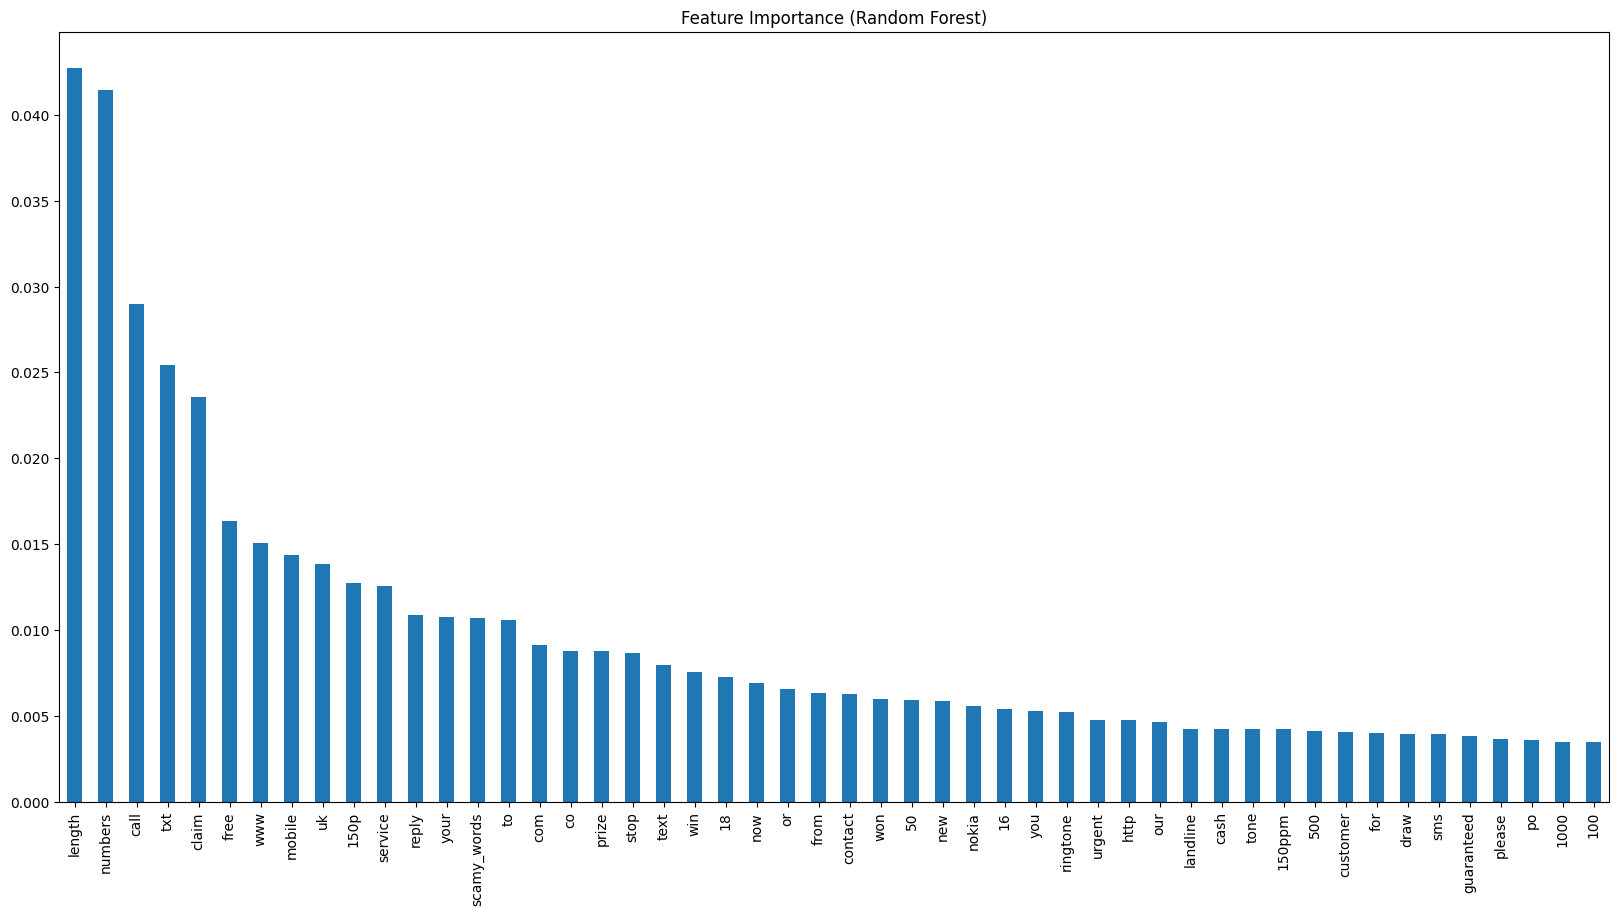

In [139]:
important_features = pd.Series(data=rfc.feature_importances_, index=col_names)
important_features.sort_values(ascending=False, inplace=True)
important_features[:50].plot(kind="bar", title = 'Feature Importance (Random Forest)', y = 'Importance', figsize=(20,10))

In [140]:
scamy_words

['call', 'text', 'won', 'now', 'free']

In [141]:
# Revise scamy words
scamy_words = ['call', 'text', 'claim', 'free', 'www']

In [142]:
train_df, val_df, test_df = return_train_val_test_sets(df)

In [143]:
pipe = Datapipeline(train_df, val_df, test_df, scamy_words=scamy_words)

In [144]:
X_train, y_train = pipe.transform(train_df)
X_val, y_val = pipe.transform(val_df)
X_test, y_test = pipe.transform(test_df)

In [145]:
print(f"Train: X shape {X_train.shape} and y shape {y_train.shape}")
print(f"Val: X shape {X_val.shape} and y shape {y_val.shape}")
print(f"Test: X shape {X_test.shape} and y shape {y_test.shape}")

Train: X shape (4692, 8199) and y shape (4692,)
Val: X shape (276, 8199) and y shape (276,)
Test: X shape (278, 8199) and y shape (278,)


In [146]:
rfc = RandomForestClassifier(random_state=SEED)
svc = SVC(random_state=SEED)

In [147]:
classifiers = [rfc, svc]

In [148]:
from sklearn.model_selection import GridSearchCV

In [149]:
params_rfc = {'n_estimators': range(50,250,50),
             'random_state': [SEED]}
params_svc = {'random_state': [SEED],
              'C': [1, 10, 100, 1000],
              'gamma': [0.001, 0.0001]}

params = {
    rfc: params_rfc,
    svc: params_svc
    }

In [150]:
for clf, params in params.items():
    cv = GridSearchCV(clf,params,cv=5)
    cv.fit(X_train, y_train)
    y_val_pred = cv.predict(X_val)
    classification_report_instance = classification_report(y_val,y_val_pred, output_dict=True)
    print(f"best params are {cv.best_params_}")
    print(f'Classifier is {clf}')
    print(classification_report(y_val,y_val_pred))
    model_results[f'{clf} with Count Vectoriser second iteration'] = classification_report_instance

best params are {'n_estimators': 100, 'random_state': 42}
Classifier is RandomForestClassifier(random_state=42)
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       239
           1       1.00      0.86      0.93        37

    accuracy                           0.98       276
   macro avg       0.99      0.93      0.96       276
weighted avg       0.98      0.98      0.98       276

best params are {'C': 1000, 'gamma': 0.001, 'random_state': 42}
Classifier is SVC(random_state=42)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       239
           1       1.00      0.97      0.99        37

    accuracy                           1.00       276
   macro avg       1.00      0.99      0.99       276
weighted avg       1.00      1.00      1.00       276



In [151]:
svc = SVC(C=1000,gamma=0.001,random_state=SEED)
svc.fit(X_train,y_train)
y_pred = svc.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       241
           1       1.00      0.84      0.91        37

    accuracy                           0.98       278
   macro avg       0.99      0.92      0.95       278
weighted avg       0.98      0.98      0.98       278



## Embeddings

## Using Glove

# check if data contains glove embeddings else download

glove_embeddings_zip_path = 'data/glove.6B.zip'

if os.path.exists(glove_embeddings_zip_path):
    pass
else:
    urllib.request.urlretrieve('https://nlp.stanford.edu/data/glove.6B.zip',glove_embeddings_zip_path)


# Check if glove has been unzip, else unzip it
zip_path = 'data/glove'

if os.path.exists(zip_path):
    pass
else:
    with zipfile.ZipFile(glove_embeddings_zip_path, 'r') as zip_ref:
        zip_ref.extractall(zip_path)

embeddings_dict = {}
with open("data/glove/glove.6B.50d.txt", 'r', encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[word] = vector

train_df.text[0]

import spacy 
nlp = spacy.load("en_core_web_sm")

token_text = [nlp(token) for token in train_df['text']]

## Using doc2vec

In [152]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
import gensim

In [153]:
def preprocess_df_into_tagdoc(df, tokens_only=False, series:bool = False):
    if series == False:
        for idx, line in enumerate(df['text']):
            tokens = gensim.utils.simple_preprocess(line)
            if tokens_only:
                yield tokens
            else:
                # For training data, add tags
                yield gensim.models.doc2vec.TaggedDocument(tokens, [idx])
    else:
        for idx, line in enumerate(df):
            tokens = gensim.utils.simple_preprocess(line)
            if tokens_only:
                yield tokens
            else:
                # For training data, add tags
                yield gensim.models.doc2vec.TaggedDocument(tokens, [idx])

In [154]:
train_df, val_df, test_df = return_train_val_test_sets(df)

In [155]:
y_train = train_df.pop('spam')
y_val = val_df.pop('spam')

In [156]:
train_corpus = list(preprocess_df_into_tagdoc(train_df))
val_corpus = list(preprocess_df_into_tagdoc(val_df))
test_corpus = list(preprocess_df_into_tagdoc(test_df, tokens_only=True))

In [157]:
model = gensim.models.doc2vec.Doc2Vec(vector_size=50, min_count=2, epochs=40)

2023-01-30 13:39:56,172 : INFO : Doc2Vec lifecycle event {'params': 'Doc2Vec<dm/m,d50,n5,w5,mc2,s0.001,t3>', 'datetime': '2023-01-30T13:39:56.172117', 'gensim': '4.2.0', 'python': '3.7.12 | packaged by conda-forge | (default, Oct 26 2021, 05:35:01) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19041-SP0', 'event': 'created'}


In [158]:
model.build_vocab(train_corpus)

2023-01-30 13:39:56,534 : INFO : collecting all words and their counts
2023-01-30 13:39:56,535 : INFO : PROGRESS: at example #0, processed 0 words (0 words/s), 0 word types, 0 tags
2023-01-30 13:39:56,561 : INFO : collected 7291 word types and 5014 unique tags from a corpus of 5014 examples and 70349 words
2023-01-30 13:39:56,562 : INFO : Creating a fresh vocabulary
2023-01-30 13:39:56,591 : INFO : Doc2Vec lifecycle event {'msg': 'effective_min_count=2 retains 3638 unique words (49.90% of original 7291, drops 3653)', 'datetime': '2023-01-30T13:39:56.591104', 'gensim': '4.2.0', 'python': '3.7.12 | packaged by conda-forge | (default, Oct 26 2021, 05:35:01) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19041-SP0', 'event': 'prepare_vocab'}
2023-01-30 13:39:56,592 : INFO : Doc2Vec lifecycle event {'msg': 'effective_min_count=2 leaves 66696 word corpus (94.81% of original 70349, drops 3653)', 'datetime': '2023-01-30T13:39:56.592106', 'gensim': '4.2.0', 'python': '3.7.12 | packa

In [159]:
model.train(train_corpus, total_examples=model.corpus_count, epochs=model.epochs)

2023-01-30 13:39:57,064 : INFO : Doc2Vec lifecycle event {'msg': 'training model with 3 workers on 3638 vocabulary and 50 features, using sg=0 hs=0 sample=0.001 negative=5 window=5 shrink_windows=True', 'datetime': '2023-01-30T13:39:57.064109', 'gensim': '4.2.0', 'python': '3.7.12 | packaged by conda-forge | (default, Oct 26 2021, 05:35:01) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19041-SP0', 'event': 'train'}
2023-01-30 13:39:57,432 : INFO : EPOCH 0: training on 70349 raw words (58623 effective words) took 0.4s, 165137 effective words/s
2023-01-30 13:39:57,795 : INFO : EPOCH 1: training on 70349 raw words (58634 effective words) took 0.4s, 166972 effective words/s
2023-01-30 13:39:58,159 : INFO : EPOCH 2: training on 70349 raw words (58580 effective words) took 0.4s, 165881 effective words/s
2023-01-30 13:39:58,527 : INFO : EPOCH 3: training on 70349 raw words (58516 effective words) took 0.4s, 164404 effective words/s
2023-01-30 13:39:58,895 : INFO : EPOCH 4: traini

In [160]:
train_vector_list = [model.infer_vector(tokens[0]) for tokens in train_corpus]
val_vector_list = [model.infer_vector(tokens[0]) for tokens in val_corpus]
test_vector_list = [model.infer_vector(tokens) for tokens in test_corpus]

In [161]:
X_train = np.array(train_vector_list)
X_val = np.array(val_vector_list)
X_test = np.array(test_vector_list)

In [162]:
print(f"Train: X shape {X_train.shape} and y shape {y_train.shape}")
print(f"Val: X shape {X_val.shape} and y shape {y_val.shape}")
print(f"Test: X shape {X_test.shape} and y shape {y_test.shape}")

Train: X shape (5014, 50) and y shape (5014,)
Val: X shape (279, 50) and y shape (279,)
Test: X shape (279, 50) and y shape (278,)


In [163]:
classifiers = [rfc, svc, knn, logreg]

In [164]:
for clf in classifiers:
    clf.fit(X_train, y_train)
    y_val_pred = clf.predict(X_val)
    classification_report_instance = classification_report(y_val,y_val_pred, output_dict=True)
    print(f'Classifier is {clf}')
    print(classification_report(y_val,y_val_pred))
    model_results[f'{clf} with doc2vec'] = classification_report_instance

Classifier is RandomForestClassifier(random_state=42)
              precision    recall  f1-score   support

           0       0.93      1.00      0.96       241
           1       0.95      0.50      0.66        38

    accuracy                           0.93       279
   macro avg       0.94      0.75      0.81       279
weighted avg       0.93      0.93      0.92       279

Classifier is SVC(C=1000, gamma=0.001, random_state=42)
              precision    recall  f1-score   support

           0       0.93      1.00      0.96       241
           1       0.95      0.55      0.70        38

    accuracy                           0.94       279
   macro avg       0.94      0.77      0.83       279
weighted avg       0.94      0.94      0.93       279

Classifier is KNeighborsClassifier()
              precision    recall  f1-score   support

           0       0.93      1.00      0.96       241
           1       1.00      0.53      0.69        38

    accuracy                       

## Embeddings with Preprocessing

In [165]:
train_df, val_df, test_df = return_train_val_test_sets(df)

In [166]:
pipe = Datapipeline(train_df, val_df, test_df, countVec=False, tfidf=False, return_text=True)

In [167]:
train_text ,X_train, y_train = pipe.transform(train_df)
val_text ,X_val, y_val = pipe.transform(val_df)
test_text, X_test, y_test = pipe.transform(test_df)

In [168]:
train_corpus = list(preprocess_df_into_tagdoc(train_text, series=True))
val_corpus = list(preprocess_df_into_tagdoc(val_text, series=True))
test_corpus = list(preprocess_df_into_tagdoc(test_text, tokens_only=True, series=True))

In [169]:
train_vector_list = [model.infer_vector(tokens[0]) for tokens in train_corpus]
val_vector_list = [model.infer_vector(tokens[0]) for tokens in val_corpus]
test_vector_list = [model.infer_vector(tokens) for tokens in test_corpus]

In [170]:
assert len(train_vector_list) == len(X_train)
assert len(val_vector_list) == len(X_val)
assert len(test_vector_list) == len(X_test)

In [171]:
X_train = np.concatenate([train_vector_list, X_train], axis=1)
X_val = np.concatenate([val_vector_list, X_val], axis=1)
X_test = np.concatenate([test_vector_list, X_test], axis=1)

In [172]:
print(f"Train: X shape {X_train.shape} and y shape {y_train.shape}")
print(f"Val: X shape {X_val.shape} and y shape {y_val.shape}")
print(f"Test: X shape {X_test.shape} and y shape {y_test.shape}")

Train: X shape (4692, 53) and y shape (4692,)
Val: X shape (276, 53) and y shape (276,)
Test: X shape (278, 53) and y shape (278,)


In [173]:
rfc = RandomForestClassifier(random_state=SEED)
svc = SVC(random_state=SEED)
knn = KNeighborsClassifier()
logreg = LogisticRegression()

In [174]:
classifiers = [rfc, svc, knn, logreg]

In [175]:
for clf in classifiers:
    clf.fit(X_train, y_train)
    y_val_pred = clf.predict(X_val)
    print(f'Classifier is {clf}')
    print(classification_report(y_val,y_val_pred))

Classifier is RandomForestClassifier(random_state=42)
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       239
           1       1.00      0.76      0.86        37

    accuracy                           0.97       276
   macro avg       0.98      0.88      0.92       276
weighted avg       0.97      0.97      0.97       276

Classifier is SVC(random_state=42)
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       239
           1       0.97      0.89      0.93        37

    accuracy                           0.98       276
   macro avg       0.98      0.94      0.96       276
weighted avg       0.98      0.98      0.98       276

Classifier is KNeighborsClassifier()
              precision    recall  f1-score   support

           0       1.00      0.96      0.98       239
           1       0.78      0.97      0.87        37

    accuracy                           0.96       276
  

In [176]:
params_rfc = {'n_estimators': range(50,250,50),
             'random_state': [SEED]}
params_svc = {'random_state': [SEED],
              'C': [1, 10, 100, 1000],
              'gamma': [0.001, 0.0001]}

params = {
    rfc: params_rfc,
    svc: params_svc
    }

In [177]:
for model, params in params.items():
    cv = GridSearchCV(model,params,cv=5)
    cv.fit(X_train, y_train)
    y_val_pred = cv.predict(X_val)
    classification_report_instance = classification_report(y_val,y_val_pred, output_dict=True)
    print(f"best params are {cv.best_params_}")
    print(f'Classifier is {model}')
    print(classification_report(y_val,y_val_pred))
    model_results[f'{model} with doc2vec processed'] = classification_report_instance

best params are {'n_estimators': 200, 'random_state': 42}
Classifier is RandomForestClassifier(random_state=42)
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       239
           1       1.00      0.76      0.86        37

    accuracy                           0.97       276
   macro avg       0.98      0.88      0.92       276
weighted avg       0.97      0.97      0.97       276

best params are {'C': 1000, 'gamma': 0.001, 'random_state': 42}
Classifier is SVC(random_state=42)
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       239
           1       0.94      0.92      0.93        37

    accuracy                           0.98       276
   macro avg       0.97      0.96      0.96       276
weighted avg       0.98      0.98      0.98       276



In [178]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Model Performance')

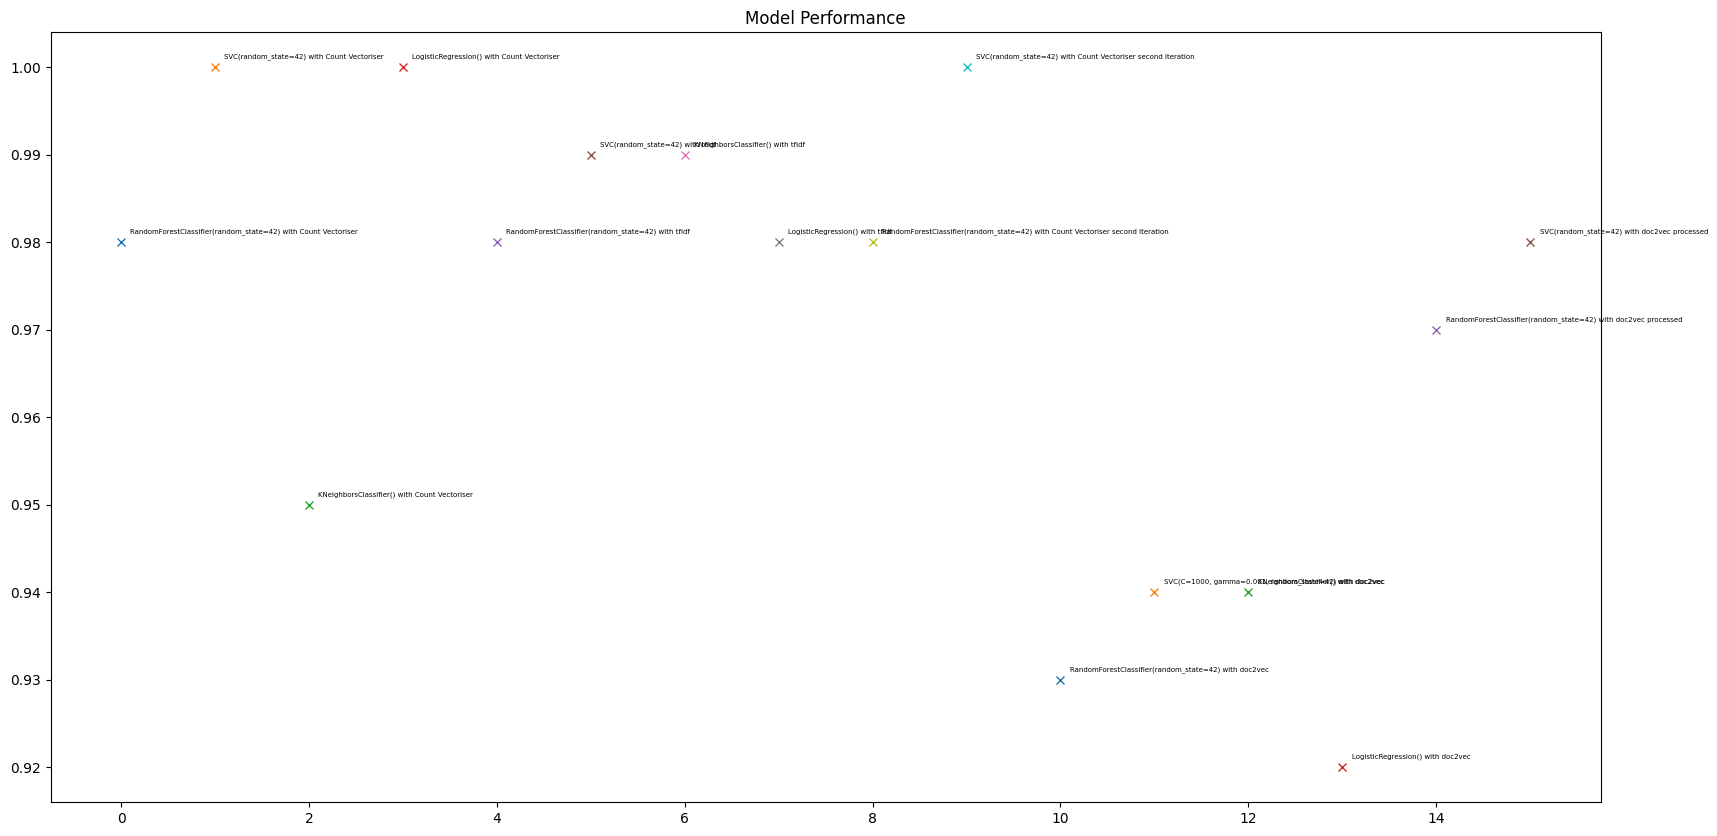

In [179]:
plt.figure(figsize=((20,10)))
for idx, model in enumerate(model_results.keys()):
    plt.plot(idx,round(float(model_results[model]['accuracy']),2), marker = "x")
    plt.text(idx+0.1,round(float(model_results[model]['accuracy']),2)+0.001, model, fontsize = 5)

plt.title("Model Performance")

# Best performing models

Both model uses the countvectoriser

In [180]:
df = pd.read_csv(data_path, encoding='ISO-8859-1')
df = df.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'], axis=1)
df.columns = ['spam','text']
df.spam = df.spam.apply(lambda x: 0 if x == 'ham' else 1)

In [181]:
df

,spam,text
0,0,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives around here though"
...,...,...
5567,1,"This is the 2nd time we have tried 2 contact u. U have won the å£750 Pound prize. 2 claim is easy, call 087187272008 NOW1! Only 10p per minute. BT-national-rate."
5568,0,Will Ì_ b going to esplanade fr home?
5569,0,"Pity, * was in mood for that. So...any other suggestions?"
5570,0,The guy did some bitching but I acted like i'd be interested in buying something else next week and he gave it to us for free


In [182]:
train_df, val_df, test_df = return_train_val_test_sets(df)
pipe = Datapipeline(train_df, val_df, test_df)

In [183]:
X_train, y_train = pipe.transform(train_df)
X_test, y_test = pipe.transform(test_df)

In [184]:
X_train.shape

(4692, 8199)

In [185]:
logreg = LogisticRegression(random_state=SEED)
logreg.fit(X_train,y_train)
y_pred = logreg.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       241
           1       1.00      0.84      0.91        37

    accuracy                           0.98       278
   macro avg       0.99      0.92      0.95       278
weighted avg       0.98      0.98      0.98       278



In [186]:
svc = SVC(random_state=SEED)
svc.fit(X_train,y_train)
y_pred = svc.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       241
           1       1.00      0.84      0.91        37

    accuracy                           0.98       278
   macro avg       0.99      0.92      0.95       278
weighted avg       0.98      0.98      0.98       278



# Save best model

In [187]:
import pickle

In [188]:
pickle.dump(logreg, open('logreg_model','wb'))
pickle.dump(svc, open('svc_model','wb'))

In [189]:
with open('logreg_model', 'rb') as f:
    test_model = pickle.load(f)

In [190]:
test_model.predict(X_train[0].reshape(1,-1))

array([0], dtype=int64)

In [191]:
len(X_test)

278

# Testing out the pipeline function

In [306]:
df

,spam,text
0,0,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives around here though"
...,...,...
5567,1,"This is the 2nd time we have tried 2 contact u. U have won the å£750 Pound prize. 2 claim is easy, call 087187272008 NOW1! Only 10p per minute. BT-national-rate."
5568,0,Will Ì_ b going to esplanade fr home?
5569,0,"Pity, * was in mood for that. So...any other suggestions?"
5570,0,The guy did some bitching but I acted like i'd be interested in buying something else next week and he gave it to us for free


In [208]:
test_model.predict(X.reshape(1,-1))

array([1], dtype=int64)

In [307]:
y_pred = test_model.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       241
           1       1.00      0.84      0.91        37

    accuracy                           0.98       278
   macro avg       0.99      0.92      0.95       278
weighted avg       0.98      0.98      0.98       278



In [214]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [308]:
input_string = "Wa lau aye, meet tomorrow cannot ah "

In [309]:
input_string_pd = pd.DataFrame({'spam':1, 'text':input_string}, index=[0])

In [310]:
X , _ = pipe.transform(input_string_pd)

In [311]:
test_model.predict(X)

array([0], dtype=int64)

In [313]:
test_model.predict_proba(X)[0]

array([0.99871559, 0.00128441])